In [187]:
import numpy as np
import matplotlib.pyplot as plt
import torch

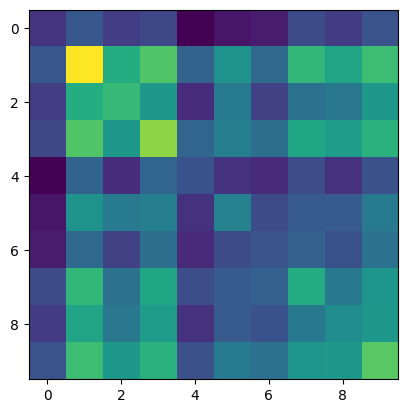

In [24]:
# generate a random positive definite matrix
n = 10
A = np.random.rand(n, n)
A = A @ A.T
plt.imshow(A)

In [25]:
A.shape

(10, 10)

In [26]:
# compute the cholesky decomposition
L = cholesky(A)

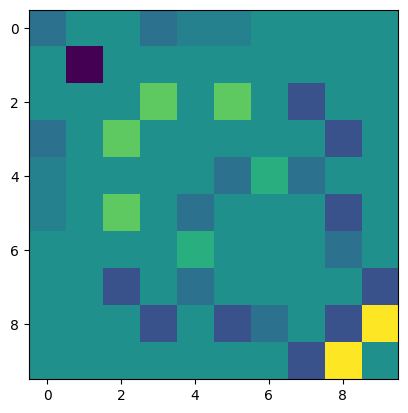

In [27]:
diffs = A - L @ L.T
# plot the difference between A and LL^T
plt.imshow(diffs)

In [28]:
# print the absolute difference (should be very small)
print(np.max(np.abs(diffs)))

8.881784197001252e-16


In [29]:
import numpy as np


def cholesky(A):
    n = A.shape[0]
    L = np.zeros(A.shape)
    for j in range(n):  # loop over columns
        v_j_to_n = A[j:, j].copy()  # vector from j-th element to the end, size n-j
        for k in range(j):
            v_j_to_n -= L[j:, k] * L[j, k]
        L[j, j] = np.sqrt(v_j_to_n[0])  # Diagonal element
        L[j + 1 :, j] = v_j_to_n[1:] / L[j, j]  # Off-diagonal elements
    return L


# Test the function
A = np.array([[4, 12, -16], [12, 37, -43], [-16, -43, 98]], dtype=float)
L = cholesky(A)
print("L:")
print(L)
print("\nL @ L.T:")
print(L @ L.T)
print("\nOriginal A:")
print(A)
print("\nDifference:")
print(np.abs(A - L @ L.T).max())

L:
[[ 2.  0.  0.]
 [ 6.  1.  0.]
 [-8.  5.  3.]]

L @ L.T:
[[  4.  12. -16.]
 [ 12.  37. -43.]
 [-16. -43.  98.]]

Original A:
[[  4.  12. -16.]
 [ 12.  37. -43.]
 [-16. -43.  98.]]

Difference:
0.0


From the new notes.
1. first we partition A into a 2X2 blocked matrix
2. then we compute the first scalar entry $\lambda_11$
3. then we compute the vector $l_{21}$
4. then we take the lower triangular part of the difference $A_{22} -l_{21} l_{21}^T$.
this will be the block for our next iter 

In [189]:
def cholesky_variant_three(A):
    """Cholesky decomposition of a positive definite matrix, variant 3, column by column.
    with in-place operations.

    Args:
        A (torch.Tensor): symmetric positive definite matrix, shape (n, n)

    Returns:
        torch.Tensor: the Cholesky factor, i.e., lower triangular matrix L such that A = LL^T
    """
    A = torch.tril(A) # ignore the upper triangular part which is identical to the lower triangular part
    n = A.shape[0] # dimension of the matrix
    if n == 1:
        # base case, A is 1x1 matrix
        A[0, 0] = torch.sqrt(A[0, 0])
        return A

    for j in range(n):
        # overwrite the top diagonal element (scalar block 1,1), take the square root
        A[j, j] = torch.sqrt(A[j, j])
        # overwrite the column below the diagonal element (vector block 2,1), divide by the diagonal element
        A[j + 1 :, j] /= A[j, j]
        # update the bottom-right submatrix (matrix block 2,2), subtract the outer product of the column computed above
        # the cholesky factorization of the bottom-right submatrix is computed recursively, will be done in the next iteration.
        A[j + 1 :, j + 1 :] -= torch.tril(torch.outer(A[j + 1 :, j], A[j + 1 :, j]))
        # i.e., next iteration will be $Cholesky(A[j + 1 :, j + 1 :])$ of this new submatrix.
    return A

In [218]:
# generate a random positive definite matrix
from torch_modules.generate_data import generate_well_conditioned_spd

n= 100
A = generate_well_conditioned_spd(n, condition_number=10)

In [219]:
A

array([[ 4.80635114,  0.28673378,  0.12799706, ..., -0.49865354,
        -0.3649963 , -0.11368197],
       [ 0.28673378,  3.76615229, -0.34212763, ..., -0.53279346,
        -0.10413254,  0.25087219],
       [ 0.12799706, -0.34212763,  4.18624088, ..., -0.22364698,
        -0.03156849, -0.17575265],
       ...,
       [-0.49865354, -0.53279346, -0.22364698, ...,  4.47856631,
        -0.04610506, -0.32252311],
       [-0.3649963 , -0.10413254, -0.03156849, ..., -0.04610506,
         3.87039718,  0.25502599],
       [-0.11368197,  0.25087219, -0.17575265, ..., -0.32252311,
         0.25502599,  3.64247317]])

In [191]:
DTYPE = torch.float64
# measure the time
import time

start = time.time()
modified_A = cholesky_variant_three(torch.tensor(A, dtype=DTYPE))
end = time.time()
column_variant_three_time = end - start

In [62]:
# loop over data types. run cholesky_variant_three on the matrix A and measure record the entrywise error torch.tensor(A, dtype=DTYPE) - modified_A @ modified_A.T

DTYPES = [torch.float16, torch.float32, torch.float64]
errors = []
for DTYPE in DTYPES:
    with torch.no_grad():
        modified_A = cholesky_variant_three(torch.tensor(A, dtype=DTYPE))
        error_all = torch.tensor(A, dtype=DTYPE) - modified_A @ modified_A.T
        errors.append(error_all)

['1.95e-02', '1.43e-06', '5.33e-15']


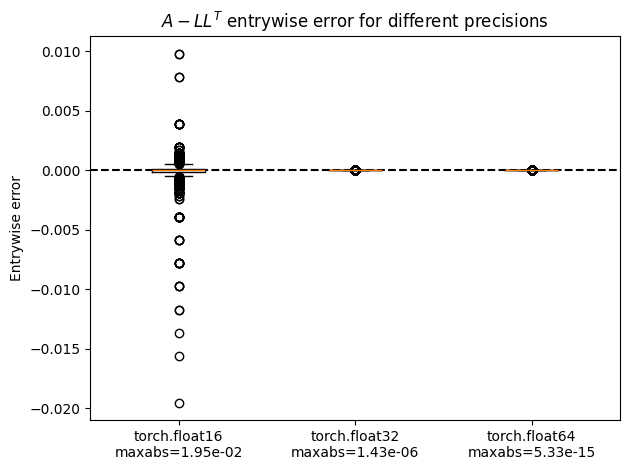

In [63]:
# for err in errors:
#     print(err)
# calculate the max absolute error for each data type
max_errors = [torch.max(torch.abs(err)).item() for err in errors]
# convert to exponent notation
max_errors = [f"{max_error:.2e}" for max_error in max_errors]
print(max_errors)
# plot boxplot of the entrywise errors
plt.boxplot([err.flatten() for err in errors])
xlabels = [f"{str(dtype)}\nmaxabs={max_errors[i]}" for i, dtype in enumerate(DTYPES)]
plt.gca().set_xticklabels(xlabels)
plt.ylabel('Entrywise error')
# horizontal line at 0
plt.axhline(0, color='black', linestyle="dashed")
plt.title(r"$A - LL^T$ entrywise error for different precisions")
plt.tight_layout()

In [64]:
# check that the modified matrix does what we expect
diffs = torch.tensor(A, dtype=DTYPE) - modified_A @ modified_A.T

In [65]:
# min and max values of the difference
torch.min(diffs), torch.max(diffs)

(tensor(-5.3291e-15, dtype=torch.float64),
 tensor(4.4409e-15, dtype=torch.float64))

Text(0.5, 1.0, '$LL^T$')

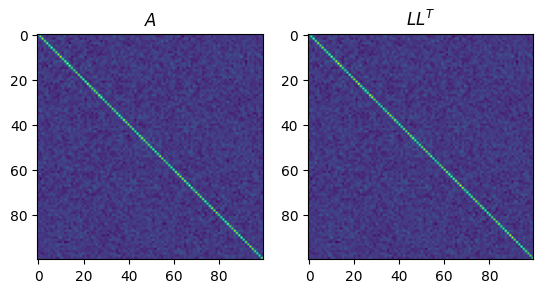

In [66]:
# show A and the cholesky decomposition side by side
plt.subplot(1, 2, 1)
plt.imshow(A)
plt.title(r"$A$")
plt.subplot(1, 2, 2)
plt.imshow(modified_A @ modified_A.T)
plt.title(r"$LL^T$")


### blocked variant 3
we divide the matrix into `block_size` chunks and solve recursively:
1. $L_{11} = \text{Chol}(A_{11})$
2. $L_{21} = A_{21} (L_{11}^T)^{-1} \rightarrow L_{21} L_{11}^T= A_{21} \rightarrow  L_{11} L_{21}^T = A_{21}^T$ which is a lower triangular system with multiple columns. we're solving for $L_{21}$
3. $L_{22} = Tril(A_{22} - L_{21}L_{21}^T)$

In [192]:
def choelesky_variant_three_blocked(A: torch.Tensor, block_size: int):
    """Blocked variant 3 of the Cholesky decomposition of a positive definite matrix.

    Args:
        A (torch.Tensor): symmetric positive definite matrix, shape (n, n)
        block_size (int): block size

    Returns:
        (torch.Tensor): A modified in-place to contain the Cholesky factor L
    """
    n = A.shape[0]
    # start by working just on the lower triangular part
    A = torch.tril(A)
    # loop and partition the matrix into blocks
    for j in range(0, n, block_size):
        # print(f"partition number j={j}")

        # L_11 is the cholesky of the original block (1, 1)
        # we need it for the next two blocks
        # start by the non-blocked cholesky variant 3, swap to blocked later
        # (block_size, block_size) block
        L_11 = cholesky_variant_three(A[j : j + block_size, j : j + block_size])
        A[j : j + block_size, j : j + block_size] = L_11

        # L_{21} involves solving the lower triangular system with multiple columns
        # (block_size, n-j-block_size) block
        L_21 = torch.linalg.solve_triangular(L_11, A[j + block_size : n, j : j + block_size].T, upper=False).T
        # modify A in place
        A[j + block_size : n, j : j + block_size] = L_21

        # L_{22} involves the cholesky (of the Schur complement? check)
        L_22 = torch.tril(A[j + block_size : n, j + block_size : n] - L_21 @ L_21.T)
        A[j + block_size : n, j + block_size : n] = L_22

    return A

### adding lazy evaluation of the kernel here
experimental below 

In [193]:
def choelesky_variant_three_blocked_lazy(A: torch.Tensor, block_size: int):
    """Blocked variant 3 of the Cholesky decomposition of a positive definite matrix.

    Args:
        A (torch.Tensor): symmetric positive definite matrix, shape (n, n)
        block_size (int): block size

    Returns:
        (torch.Tensor): A modified in-place to contain the Cholesky factor L
    """
    L_21_list = []
    n = A.shape[0]
    # start by working just on the lower triangular part
    A = torch.tril(A)
    # loop and partition the matrix into blocks
    for j in range(0, n, block_size):
        print(f"partition number j={j}")

        # L_11 is the cholesky of the original block (1, 1)
        # we need it for the next two blocks
        # start by the non-blocked cholesky variant 3, swap to blocked later
        # (block_size, block_size) block
        L_11 = cholesky_variant_three(A[j : j + block_size, j : j + block_size])
        A[j : j + block_size, j : j + block_size] = L_11

        # L_{21} involves solving the lower triangular system with multiple columns
        # (block_size, n-j-block_size) block
        L_21 = torch.linalg.solve_triangular(
            L_11, A[j + block_size : n, j : j + block_size].T, upper=False
        ).T
        # modify A in place
        A[j + block_size : n, j : j + block_size] = L_21

        # L_{22} involves the cholesky (of the Schur complement? check). the below worked
        # L_22 = torch.tril(A[j + block_size : n, j + block_size : n] - L_21 @ L_21.T)
        # A[j + block_size : n, j + block_size : n] = L_22

        # experimental below:
        # instead of the above, we modify just A_{22}[:, one block size ahead] and keep trak of L_21 to be used in the next iteration
        # (n-j-block_size, block_size) block
        A[j + block_size : n, j + block_size : j + 2 * block_size] -= (
            L_21 @ L_21.T[:, :block_size]
        )  # current block
        # now subtract all the previous L_21s at the respective positions.
        # the positions depend on the block size and the index of the L_21 in the list
        for i, L_21_dict in enumerate(L_21_list):
            old_block_counter = L_21_dict["block_counter"]
            old_L_21 = L_21_dict["matrix"]
            # TODO: might be one index back, check
            # A[j + block_size : n, j + block_size : j + 2 * block_size] -= (
            result = old_L_21 @ old_L_21.T[:, j - old_block_counter : j - old_block_counter + block_size]
            # take the relevant rows of the result to update the next A_{22} block
            A[j + block_size : n, j + block_size : j + 2 * block_size] -= result[j  - old_block_counter :, :]


        L_21_list.append({"matrix": L_21, "block_counter": j})

    return A

## TODO
use the pointers instead of storing the `L_21`

In [194]:
# generate a random positive definite matrix
from vanil_la.generate_data import generate_well_conditioned_spd

n = 100
A = generate_well_conditioned_spd(n, condition_number=10)

In [195]:
A_blocked_chol = choelesky_variant_three_blocked_lazy(
    torch.tensor(A, dtype=torch.float64), 6
)

partition number j=0
partition number j=6
partition number j=12
partition number j=18
partition number j=24
partition number j=30
partition number j=36
partition number j=42
partition number j=48
partition number j=54
partition number j=60
partition number j=66
partition number j=72
partition number j=78
partition number j=84
partition number j=90
partition number j=96


In [196]:
diffs = torch.tensor(A, dtype=torch.float64) - A_blocked_chol @ A_blocked_chol.T
# min and max values of the difference
torch.min(diffs), torch.max(diffs)

(tensor(-1.7764e-15, dtype=torch.float64),
 tensor(1.7764e-15, dtype=torch.float64))

up above is the lazy version

In [130]:
# compute wall clock time as a function of the block size
import time

block_sizes = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
times = []

for block_size in block_sizes:
    start_time = time.time()
    A_blocked_chol = choelesky_variant_three_blocked(
        torch.tensor(A, dtype=torch.float64), block_size
    )
    times.append(time.time() - start_time)

partition number j=0
partition number j=1
partition number j=2
partition number j=3
partition number j=4
partition number j=5
partition number j=6
partition number j=7
partition number j=8
partition number j=9
partition number j=10
partition number j=11
partition number j=12
partition number j=13
partition number j=14
partition number j=15
partition number j=16
partition number j=17
partition number j=18
partition number j=19
partition number j=20
partition number j=21
partition number j=22
partition number j=23
partition number j=24
partition number j=25
partition number j=26
partition number j=27
partition number j=28
partition number j=29
partition number j=30
partition number j=31
partition number j=32
partition number j=33
partition number j=34
partition number j=35
partition number j=36
partition number j=37
partition number j=38
partition number j=39
partition number j=40
partition number j=41
partition number j=42
partition number j=43
partition number j=44
partition number j=4

In [131]:
times

[0.7820160388946533,
 0.541999101638794,
 0.34523701667785645,
 0.1757678985595703,
 0.14744806289672852,
 0.1186978816986084,
 0.10522198677062988,
 0.10821294784545898,
 0.15977001190185547,
 0.32695603370666504]

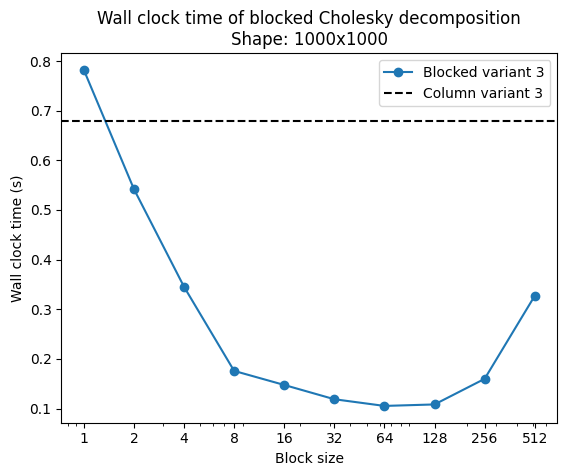

In [132]:
plt.plot(block_sizes, times, marker="o", label="Blocked variant 3")
plt.xscale("log")

# horizontal line at the column variant 3 time
plt.axhline(column_variant_three_time, color="black", linestyle="dashed", label="Column variant 3")
plt.xlabel("Block size")
plt.ylabel("Wall clock time (s)")
plt.title(f"Wall clock time of blocked Cholesky decomposition\nShape: {n}x{n}")
# xlabel at the block sizes
plt.xticks(block_sizes, block_sizes)

plt.legend()

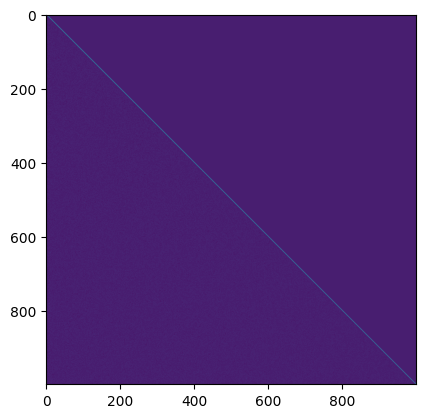

In [133]:
plt.imshow(A_blocked_chol)

Text(0.5, 1.0, '$LL^T$')

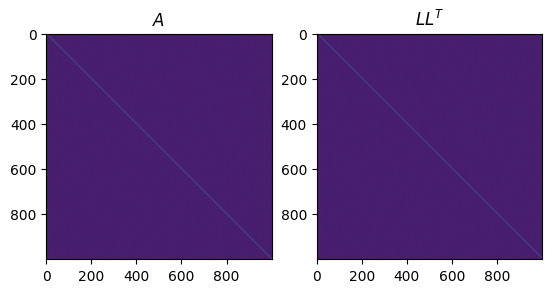

In [134]:
# imshow the difference between A and LL^T
# in two panels
plt.subplot(1, 2, 1)
plt.imshow(A)
plt.title(r"$A$")
plt.subplot(1, 2, 2)
plt.imshow(A_blocked_chol @ A_blocked_chol.T)
plt.title(r"$LL^T$")

In [135]:
# min and max values of the difference
torch.min(torch.tensor(A, dtype=DTYPE) - A_blocked_chol @ A_blocked_chol.T), torch.max(torch.tensor(A, dtype=DTYPE) - A_blocked_chol @ A_blocked_chol.T)

(tensor(-7.1054e-15, dtype=torch.float64),
 tensor(6.2172e-15, dtype=torch.float64))

In [107]:
# run the blocked cholesky on a 10 by 10 matrix with a block size of 4.
def blocked_partitions_visualize(dim: int, block_size: int):
    n = dim
    toy_matrices_array = np.zeros(((n // block_size) + 1, n, n))
    print(f"toy_matrices_array shape: {toy_matrices_array.shape}")
    # start by working just on the lower triangular part
    # loop and partition the matrix into blocks
    for i,j in enumerate(range(0, n, block_size)):
        print(f"iteration number i={i}")
        print(f"partition number j={j}")

        # compute adjusted block size for the last block
        block_size_adjusted = min(block_size, n - j)

        print(f"rows={j}:{j+block_size_adjusted}, cols={j}:{j+block_size_adjusted}")

        toy_matrices_array[i][
            j : j + block_size_adjusted, j : j + block_size_adjusted
        ] = 1

        # L_{21} involves solving the lower triangular system with multiple columns
        # (block_size, n-j-block_size) block
        print(f"rows={j + block_size_adjusted}:{n}, cols={j}:{j+block_size_adjusted}")
        toy_matrices_array[i][
            j + block_size_adjusted : n, j : j + block_size_adjusted
        ] = 2

        # L_{22} involves the cholesky (of the Schur complement? check)
        # again, should be blocked, but let's start with the non-block
        print(f"rows={j + block_size_adjusted}:{n}, cols={j + block_size_adjusted}:{n}")
        toy_matrices_array[i][
            j + block_size_adjusted : n, j + block_size_adjusted : n
        ] = 3

    return toy_matrices_array

In [108]:
visualize = blocked_partitions_visualize(10, 4)

toy_matrices_array shape: (3, 10, 10)
iteration number i=0
partition number j=0
rows=0:4, cols=0:4
rows=4:10, cols=0:4
rows=4:10, cols=4:10
iteration number i=1
partition number j=4
rows=4:8, cols=4:8
rows=8:10, cols=4:8
rows=8:10, cols=8:10
iteration number i=2
partition number j=8
rows=8:10, cols=8:10
rows=10:10, cols=8:10
rows=10:10, cols=10:10


Text(0.5, 0.98, 'Blocked Cholesky decomposition partitions\nMatrix shape: (10, 10), block size: 4')

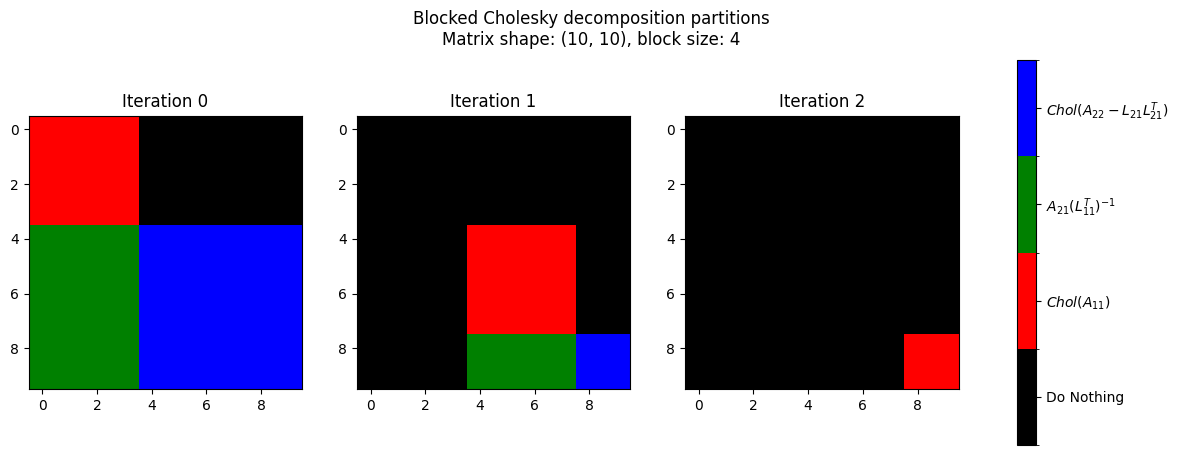

In [121]:
# # loop over the first dim in visualize and do imshow in a row.
# # each title is the iteration number
# fig, axs = plt.subplots(1, visualize.shape[0], figsize=(15, 5))

# for i, ax in enumerate(axs):
#     ax.imshow(visualize[i])
#     ax.set_title(f"Iteration {i}")

# discrete color map with labels: 0: nothing, 1: $Chol{A_{11}}$, 2: $L_{21}$, 3: $L_{22}$
import matplotlib.colors as mcolors
import matplotlib

cmap = mcolors.ListedColormap(["black", "red", "green", "blue"])
bounds = [0, 1, 2, 3, 4]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

fig, axs = plt.subplots(1, visualize.shape[0], figsize=(15, 5))

for i, ax in enumerate(axs):
    ax.imshow(visualize[i], cmap=cmap, norm=norm)
    ax.set_title(f"Iteration {i}")

# add colorbar and labels
cbar = fig.colorbar(mappable=matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs)
cbar.set_ticks([0.5, 1.5, 2.5, 3.5])
cbar.set_ticklabels(
    [
        "Do Nothing",
        r"$Chol(A_{11})$",
        r"$A_{21} (L_{11}^T)^{-1}$",
        r"$Chol(A_{22} - L_{21}L_{21}^T)$",
    ]
)
plt.suptitle(f"Blocked Cholesky decomposition partitions\nMatrix shape: {visualize[0].shape}, block size: {4}")

